In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import tensorflow as tf 

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error as rmse
from sklearn.model_selection import GridSearchCV
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/williamleith/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/williamleith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/williamleith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/williamleith/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### 1. Importing the data: 
We will be using the Feedback Prize dataset from kaggle. The dataset contains small 2-3 sentences and their relative vocabulary and grammar scores.

The dataset contains small essays written by 8th-12th grade English language learners. The essays have been scored according to the analytic measures like vocabulary and grammar. Each measure represents a component of proficiency in essay writing, with greater scores corresponding to greater proficiency in that measure. The scores range from 1.0 to 5.0 in increments of 0.5. We are going to build a model to predict the score for the essays given in the test set.

In [13]:
df = pd.read_csv('./train.csv')
df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


### 2. Visualizing the data:

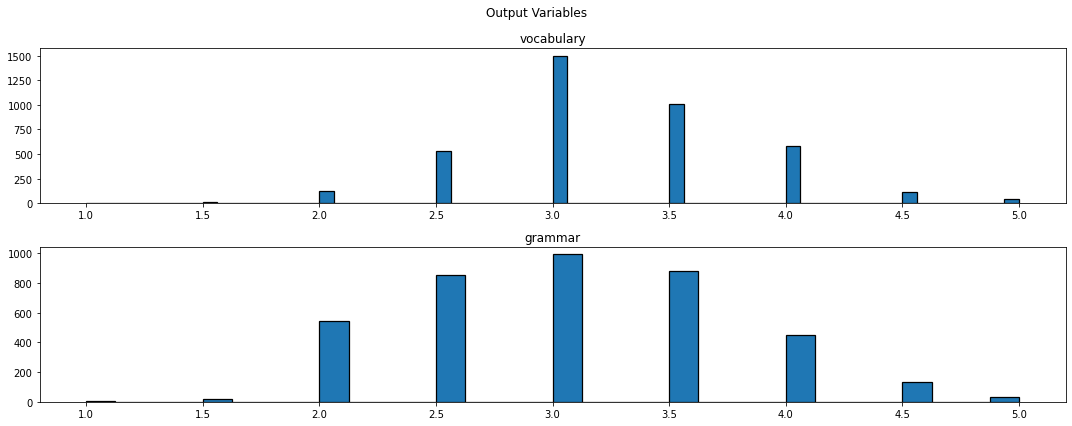

In [14]:
features = ['vocabulary', 'grammar']
target = df[features]
fig, axes = plt.subplots(2, len(features)//2, figsize=(15,6))

for i, feature in enumerate(features):
    ax = axes.flat[i]
    sns.histplot(x=feature, data=df, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    ax.set_title(feature)
    ax.set(xlabel=None, ylabel=None)
    
fig.suptitle('Output Variables')
plt.tight_layout()
plt.show()

### 3. Preprocessing the text data:

In [15]:
import nltk
from nltk.corpus import stopwords
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

def clean_text(text) : 
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+','', text)
    text = re.sub(r'@[0-9a-zA-Z]*\W+',' ' , text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\#', ' ', text)
    text = re.sub(r'\'', ' ', text)
        
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

df['full_text'] = df['full_text'].apply(lambda text: clean_text(text))

In [16]:
# !pip install jinja2
corr = target.corr()
corr.style.background_gradient(cmap='coolwarm')

,vocabulary,grammar
vocabulary,1.000000,0.654852
grammar,0.654852,1.000000


### 4. Finding the frequencies, And Splitting the data to train and test:

In [17]:
tfidf = TfidfVectorizer(max_df=0.98, min_df=2, max_features=10000)
X = tfidf.fit_transform(df['full_text'])

y = target

X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size = 0.20, random_state=42)

print(tfidf.get_feature_names_out()[:5])
print("shape of vectorized train data:",X_train.shape)
print("shape of vectorized test data: ", X_test.shape)

['abandon' 'abandoned' 'abaut' 'abble' 'abc']
shape of vectorized train data: (3128, 8405)
shape of vectorized test data:  (783, 8405)


### 5a. SVM Model:

In [ ]:
svr = SVR()
svm_model = MultiOutputRegressor(svr)
svm_model.fit(X_train, y_train)
print(svm_model.score(X_train, y_train))

0.8999762422574491


In [ ]:
y_pred_svm = svm_model.predict(X_test)
# Evaluate the regressor
svm_root_mean_squared_error = rmse(y_test, y_pred_svm)
print(f'MSE for SVM regressor: {svm_root_mean_squared_error}')

print(f'''RMSE for LSTM NN (vocabulary): {rmse(y_test['vocabulary'], y_pred_svm[:,0])}''')

print(f'''RMSE for LSTM NN (grammar): {rmse(y_test['grammar'], y_pred_svm[:,1])}''')

MSE for SVM regressor: 0.3128996998251533
RMSE for LSTM NN (vocabulary): 0.24888269090634108
RMSE for LSTM NN (grammar): 0.3769167087439656


### 5b. Neural Network Model (no LSTM)

#### a. build the model

In [ ]:
import tensorflow as tf

tf.random.set_seed(42)


# nonlinear model (without LSTM)
def build_nn_model(X):

  # layer 1 : input layer
  inp = tf.keras.Input((X.shape[1],))

  # dense layer, high regularization parameter, relu activation
  x = tf.keras.layers.Dense(units=1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(inp)

  # large dropout layer
  x = tf.keras.layers.Dropout(0.7)(x)

  # dense layer with slightly lower regularization parameter and relu activation
  x = tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.08))(x)

  # another dropout layer
  x = tf.keras.layers.Dropout(0.6)(x)

  # dense layer with smaller regularization parameter and relu activation
  x = tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05))(x)

  # another dropout layer
  x = tf.keras.layers.Dropout(0.5)(x)

  # dense layer with the same regularization paramter and relu activation
  x = tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05))(x)

  # one last dropout layer
  x = tf.keras.layers.Dropout(0.4)(x)

  predictions = tf.keras.layers.Dense(units=1, activation="relu", name="predictions")(x)

  model = tf.keras.Model(inputs=inp, outputs=predictions)

  model.compile(loss="mean_squared_error", optimizer="adam", metrics=tf.keras.metrics.RootMeanSquaredError())

  return model

#### b. fit the model on the training data

In [ ]:
# fit the nn model for grammar
grammar_nn_model = build_nn_model(X_train.todense())

tf.random.set_seed(43)

grammar_nn_model_history = grammar_nn_model.fit(X_train.todense(), 
                                                y_train['grammar'], 
                                                validation_data = (X_test.todense(), 
                                                y_test['grammar']), 
                                                batch_size=64,
                                                epochs=100,
                                                shuffle=True)

Epoch 1/100


2022-12-04 23:54:18.421170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - ETA: 0s - loss: 64.5826 - root_mean_squared_error: 1.5489

2022-12-04 23:54:22.256353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 5s 82ms/step - loss: 64.5826 - root_mean_squared_error: 1.5489 - val_loss: 10.7094 - val_root_mean_squared_error: 0.8162
Epoch 2/100
49/49 [==============================] - 3s 55ms/step - loss: 5.0707 - root_mean_squared_error: 0.6868 - val_loss: 2.6815 - val_root_mean_squared_error: 0.8248
Epoch 3/100
49/49 [==============================] - 3s 52ms/step - loss: 1.7966 - root_mean_squared_error: 0.6886 - val_loss: 1.5215 - val_root_mean_squared_error: 0.8121
Epoch 4/100
49/49 [==============================] - 3s 56ms/step - loss: 1.1601 - root_mean_squared_error: 0.7002 - val_loss: 1.1716 - val_root_mean_squared_error: 0.8033
Epoch 5/100
49/49 [==============================] - 3s 64ms/step - loss: 0.9442 - root_mean_squared_error: 0.7097 - val_loss: 1.0036 - val_root_mean_squared_error: 0.7933
Epoch 6/100
49/49 [==============================] - 3s 61ms/step - loss: 0.8238 - root_mean_squared_error: 0.7116 - val_loss: 1.0023 - val_root_mean_

In [ ]:
# fit the nn model for vocabulary
vocab_nn_model = build_nn_model(X_train.todense())

tf.random.set_seed(53)

vocab_nn_model_history = vocab_nn_model.fit(X_train.todense(), 
                                            y_train['grammar'], 
                                            validation_data = (X_test.todense(), 
                                            y_test['grammar']), 
                                            batch_size=64,
                                            epochs=100,
                                            shuffle=True)

Epoch 1/100


2022-12-05 07:56:49.979636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - ETA: 0s - loss: 65.0134 - root_mean_squared_error: 1.4545

2022-12-05 07:56:55.051534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 6s 98ms/step - loss: 65.0134 - root_mean_squared_error: 1.4545 - val_loss: 11.3927 - val_root_mean_squared_error: 0.9153
Epoch 2/100
49/49 [==============================] - 3s 54ms/step - loss: 5.4231 - root_mean_squared_error: 0.6846 - val_loss: 2.9532 - val_root_mean_squared_error: 0.8538
Epoch 3/100
49/49 [==============================] - 3s 61ms/step - loss: 1.9700 - root_mean_squared_error: 0.6922 - val_loss: 1.5449 - val_root_mean_squared_error: 0.7343
Epoch 4/100
49/49 [==============================] - 3s 57ms/step - loss: 1.2592 - root_mean_squared_error: 0.6979 - val_loss: 1.3688 - val_root_mean_squared_error: 0.8842
Epoch 5/100
49/49 [==============================] - 3s 59ms/step - loss: 0.9922 - root_mean_squared_error: 0.7056 - val_loss: 1.1777 - val_root_mean_squared_error: 0.8837
Epoch 6/100
49/49 [==============================] - 3s 56ms/step - loss: 0.8498 - root_mean_squared_error: 0.7095 - val_loss: 0.9673 - val_root_mean_

In [ ]:
# calculate RMSE for the neural network without LSTM

vocab_pred, grammar_pred = vocab_nn_model.predict(X_test).flatten(), grammar_nn_model.predict(X_test).flatten()

nn_predictions = pd.DataFrame(list(zip(vocab_pred, grammar_pred)), columns=['vocabulary', 'grammar'])

nn_root_mean_squared_error = rmse(y_test, nn_predictions)

print(f'''RMSE for non-LSTM NN (vocabulary): {rmse(y_test['vocabulary'], nn_predictions['vocabulary'])}''')

print(f'''RMSE for non-LSTM NN (grammar): {rmse(y_test['grammar'], nn_predictions['grammar'])}''')

25/25 [==============================] - 0s 19ms/step
RMSE for non-LSTM NN (vocabulary): 0.39081315964186303
RMSE for non-LSTM NN (grammar): 0.5029886492346045


AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


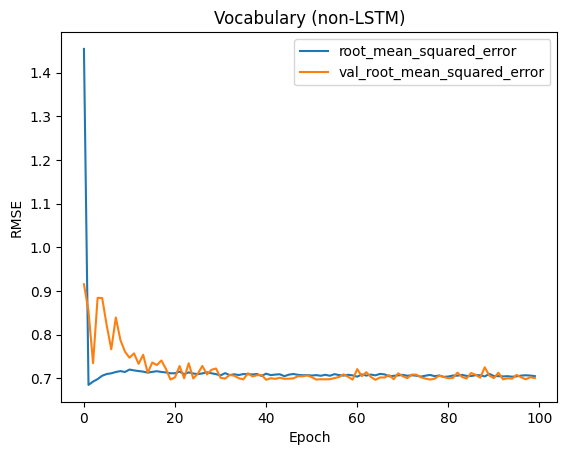

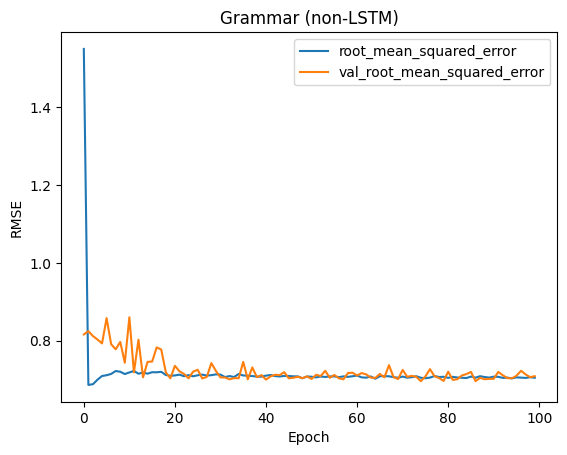

In [ ]:
import matplotlib.pyplot as plt

vocab_history_df = pd.DataFrame(vocab_nn_model_history.history)
grammar_history_df = pd.DataFrame(grammar_nn_model_history.history)

print(vocab_history_df.loc[:,['root_mean_squared_error','val_root_mean_squared_error']].plot(title='Vocabulary (non-LSTM)', xlabel='Epoch', ylabel='RMSE'))
print(grammar_history_df.loc[:,['root_mean_squared_error','val_root_mean_squared_error']].plot(title='Grammar (non-LSTM)', xlabel='Epoch', ylabel='RMSE'))


### 5c. LSTM Neural Network

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_texts, test_texts = train_test_split(df['full_text'],  test_size = 0.20, random_state=42)

In [ ]:

# for LSTM we need to pass the essays to the neural network as sequences of tokens
# as opposed to the TF-IDF vectors used by the SVM and neural network models
tokenizer = Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index

# find the number of distinct words in the training corpus (this will determine
# the dimensions of the embedding layer)
n_words = len(word_index)
print("There are", n_words, "distinct words in the training corpus")

# find the maximum essay length in the training corpus
maxlen = -1
for text in train_texts:
    length = len(text.split(' '))
    if length > maxlen:
        maxlen = length 


print(f'The longest text in the training corpus is {maxlen} words long')

# convert texts to sequences and pad them so that they are all the same length
train_sequences = tokenizer.texts_to_sequences(train_texts)
# rounding the maximum essay length to the nearest hundred
max_word_count = 600
X_train_seq = pad_sequences(train_sequences, maxlen=max_word_count, truncating='post')

test_sequences = tokenizer.texts_to_sequences(test_texts)
X_test_seq = pad_sequences(test_sequences, maxlen=max_word_count, truncating='post')




There are 19539 distinct words in the training corpus
The longest text in the training corpus is 577 words long


In [ ]:
def build_lstm_model(X):

  # input layer
  input = tf.keras.layers.Input(shape=(max_word_count))
  # trained embedding layer
  embeddings = tf.keras.layers.Embedding(n_words + 1, 1024, input_length=max_word_count)(input)
  # LSTM layer
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024))(embeddings)

  # dense layer, high regularization parameter, relu activation
  x = tf.keras.layers.Dense(units=1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1))(x)

  # large dropout layer
  x = tf.keras.layers.Dropout(0.7)(x)

  # dense layer with slightly lower regularization parameter and relu activation
  x = tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.08))(x)

  # another dropout layer
  x = tf.keras.layers.Dropout(0.6)(x)

  # dense layer with smaller regularization parameter and relu activation
  x = tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05))(x)

  # another dropout layer
  x = tf.keras.layers.Dropout(0.5)(x)

  # dense layer with the same regularization paramter and relu activation
  x = tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05))(x)

  # one last dropout layer
  x = tf.keras.layers.Dropout(0.4)(x)

  predictions = tf.keras.layers.Dense(units=1, activation="relu", name="predictions")(x)

  # output layer
  model = tf.keras.Model(inputs=input, outputs=predictions)
  model.compile(loss="mean_squared_error", optimizer="adam", metrics=tf.keras.metrics.RootMeanSquaredError(name='RootMeanSquredError'))

  return model



In [ ]:
tf.random.set_seed(2342)

# fit the LSTM model for vocabulary
vocab_lstm_model = build_lstm_model(X_train_seq)

vocab_lstm_history = vocab_lstm_model.fit(X_train_seq, 
                                          y_train['vocabulary'], 
                                          batch_size=64, 
                                          epochs=100,
                                          validation_data = [X_test_seq, y_test['vocabulary']])

# fit the LSTM model for grammar
grammar_lstm_model = build_lstm_model(X_train_seq)

grammar_lstm_history = grammar_lstm_model.fit(X_train_seq, 
                                              y_train['grammar'], 
                                              batch_size=64, 
                                              epochs=100,
                                              validation_data = [X_test_seq, y_test['grammar']])


Epoch 1/100


2022-12-05 08:05:15.824821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 08:05:16.222220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 08:05:16.268957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 08:05:20.318156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 08:05:20.343262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - ETA: 0s - loss: 91.8661 - RootMeanSquredError: 1.9175

2022-12-05 08:06:52.981964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 08:06:53.107725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 08:06:53.121431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 108s 2s/step - loss: 91.8661 - RootMeanSquredError: 1.9175 - val_loss: 35.2064 - val_RootMeanSquredError: 1.6912
Epoch 2/100
49/49 [==============================] - 85s 2s/step - loss: 22.3672 - RootMeanSquredError: 0.6557 - val_loss: 16.2057 - val_RootMeanSquredError: 1.1495
Epoch 3/100
49/49 [==============================] - 87s 2s/step - loss: 11.8219 - RootMeanSquredError: 0.6611 - val_loss: 9.4965 - val_RootMeanSquredError: 0.9636
Epoch 4/100
49/49 [==============================] - 87s 2s/step - loss: 7.2871 - RootMeanSquredError: 0.6397 - val_loss: 6.2437 - val_RootMeanSquredError: 0.8938
Epoch 5/100
49/49 [==============================] - 89s 2s/step - loss: 4.8975 - RootMeanSquredError: 0.6093 - val_loss: 4.4504 - val_RootMeanSquredError: 0.8569
Epoch 6/100
49/49 [==============================] - 86s 2s/step - loss: 3.4418 - RootMeanSquredError: 0.5310 - val_loss: 3.5126 - val_RootMeanSquredError: 0.9234
Epoch 7/100
49/49 [=========

2022-12-05 10:05:41.100436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 10:05:41.391013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 10:05:41.410231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 10:05:44.345230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 10:05:44.370029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - ETA: 0s - loss: 95.0906 - RootMeanSquredError: 1.9844

2022-12-05 10:07:13.108127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 10:07:13.241718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 10:07:13.255470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 102s 2s/step - loss: 95.0906 - RootMeanSquredError: 1.9844 - val_loss: 40.3290 - val_RootMeanSquredError: 1.6972
Epoch 2/100
49/49 [==============================] - 85s 2s/step - loss: 26.6571 - RootMeanSquredError: 0.7633 - val_loss: 20.0250 - val_RootMeanSquredError: 1.3094
Epoch 3/100
49/49 [==============================] - 83s 2s/step - loss: 14.8464 - RootMeanSquredError: 0.6670 - val_loss: 12.9055 - val_RootMeanSquredError: 1.3074
Epoch 4/100
49/49 [==============================] - 84s 2s/step - loss: 9.5572 - RootMeanSquredError: 0.5812 - val_loss: 8.8130 - val_RootMeanSquredError: 1.1438
Epoch 5/100
49/49 [==============================] - 84s 2s/step - loss: 6.6301 - RootMeanSquredError: 0.5181 - val_loss: 6.8407 - val_RootMeanSquredError: 1.2271
Epoch 6/100
49/49 [==============================] - 83s 2s/step - loss: 4.8274 - RootMeanSquredError: 0.4628 - val_loss: 5.2370 - val_RootMeanSquredError: 1.1317
Epoch 7/100
49/49 [========

In [ ]:
vocab_pred, grammar_pred = vocab_lstm_model.predict(X_test_seq).flatten(), grammar_lstm_model.predict(X_test_seq).flatten()

lstm_predictions = pd.DataFrame(list(zip(vocab_pred, grammar_pred)), columns=['vocabulary', 'grammar'])

lstm_root_mean_squared_error = rmse(y_test, lstm_predictions)

print(f'''RMSE for LSTM NN (vocabulary): {rmse(y_test['vocabulary'], lstm_predictions['vocabulary'])}''')

print(f'''RMSE for LSTM NN (grammar): {rmse(y_test['grammar'], lstm_predictions['grammar'])}''')



25/25 [==============================] - 5s 188ms/step
RMSE for LSTM NN (vocabulary): 0.3294834529356595
RMSE for LSTM NN (grammar): 0.488301254208074


AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


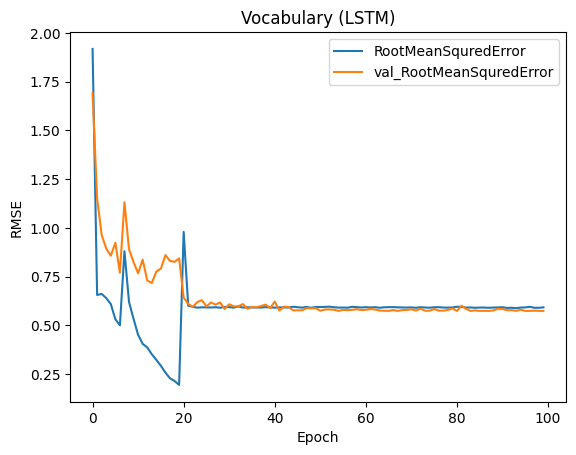

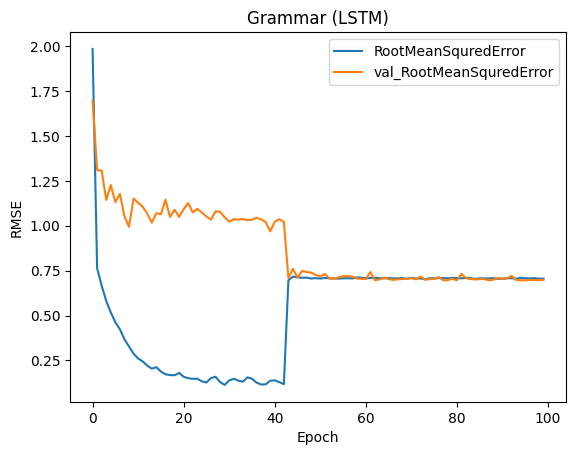

In [ ]:
vocab_lstm_history_df = pd.DataFrame(vocab_lstm_history.history)
grammar_lstm_history_df = pd.DataFrame(grammar_lstm_history.history)

vocab_lstm_history_df

print(vocab_lstm_history_df.loc[:,['RootMeanSquredError','val_RootMeanSquredError']].plot(title='Vocabulary (LSTM)', xlabel='Epoch', ylabel='RMSE'))
print(grammar_lstm_history_df.loc[:,['RootMeanSquredError','val_RootMeanSquredError']].plot(title='Grammar (LSTM)', xlabel='Epoch', ylabel='RMSE'))

### 5d. XGBoost

In [ ]:
# !pip3 install xgboost
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
def xgboost_syntax(y_choice, x_train, x_test, m):
    model = tf.keras.models.Model(
    m.input, 
    m.get_layer('predictions').output
    )
    if y_choice=='grammar':
        data_y_train = y_train['grammar']
        data_y_test = y_test['grammar']
    elif y_choice=='vocabulary':
        data_y_train = y_train['vocabulary']
        data_y_test = y_test['vocabulary']
    X_train_features = model.predict(x_train)
    X_test_features = model.predict(x_test)
    xgb = xg.XGBRegressor(objective ='reg:squarederror',n_estimators = 100)
    xgb.fit(X_train_features, data_y_train)
    y_pred = xgb.predict(X_test_features)
    loss_metrics = MSE(data_y_test, y_pred)
    return [y_pred, data_y_test, loss_metrics, ]

In [ ]:
[y_pred, y_true, loss_metrics1] = xgboost_syntax('vocabulary', X_train_seq, X_test_seq, vocab_lstm_model)

2022-12-08 15:34:50.584409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 15:34:50.707978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 15:34:50.730944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 7s 272ms/step


In [ ]:
print("The root mean squared error for XGBooster in Vocabulary is: ",np.sqrt(loss_metrics1))

The root mean squared error for XGBooster in Vocabulary is:  0.5745763928203409


In [ ]:
[y_pred, y_true, loss_metrics2] = xgboost_syntax('grammar', X_train_seq, X_test_seq, grammar_lstm_model)

2022-12-08 15:38:27.715608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 15:38:27.834943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 15:38:27.857804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 7s 276ms/step


In [ ]:
print("The mean squared error for XGBooster in Grammar is: ", np.sqrt(loss_metrics2))

The mean squared error for XGBooster in Grammar is:  0.6962841007596388


### 5e. Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

score = linear_model.score(X_train, y_train)
y_pred_ols = linear_model.predict(X_test)
root_mean_square_error = rmse(y_test, y_pred_ols)
root_mean_square_error_vocab = rmse(y_test['vocabulary'], y_pred_ols[:,0])
root_mean_square_error_grammar = rmse(y_test['grammar'], y_pred_ols[:,1])

In [ ]:
print("Linear regression: predictions using the test set:\n", y_pred_ols)

Linear regression: predictions using the test set:
 [[3.31147635 3.33054414]
 [2.41467086 3.2337112 ]
 [2.83047203 2.08413721]
 ...
 [2.62188447 3.17155094]
 [3.57416135 2.64690728]
 [3.09890913 2.83082548]]


In [ ]:
print("RMSE for linear regression: ", root_mean_square_error)
print("RMSE for linear regression(vocabulary): ", root_mean_square_error_vocab)
print("RMSE for linear regression(grammar): ", root_mean_square_error_grammar)

RMSE for linear regression:  0.758652510760916
RMSE for linear regression(vocabulary):  0.5332876338886128
RMSE for linear regression(grammar):  0.9840173876332193


### 5f. Ridge Regression

In [18]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# look for approriate alpha
ridge = Ridge(normalize = True)
search = GridSearchCV(estimator=ridge, param_grid={'alpha': list(range(-5, 15))}, scoring='neg_mean_squared_error', n_jobs=1, refit=True, cv=10)
search.fit(X_train, y_train)
alpha = search.best_params_
print(abs(search.best_score_))

print(f'alpha: {alpha}')

0.32335724638776175
alpha: {'alpha': 6}


In [19]:
ridge_model = Ridge(normalize=True, alpha=6)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)


In [20]:
print("Ridge regression: predictions using the test set:\n", y_pred_ridge)

Ridge regression: predictions using the test set:
 [[2.96062717 2.75022613]
 [3.16598011 2.98318606]
 [3.15249902 3.05103537]
 ...
 [3.10696213 2.98352455]
 [3.52339585 3.3553581 ]
 [3.1388176  2.75981097]]


In [21]:
root_mean_square_error = rmse(y_test, y_pred_ridge)  
root_mean_square_error_vocab = rmse(y_test['vocabulary'], y_pred_ridge[:,0])
root_mean_square_error_grammar = rmse(y_test['grammar'], y_pred_ridge[:,1])

print("RMSE for ridge regression: ", root_mean_square_error)
print("RMSE for ridge regression(vocabulary): ", root_mean_square_error_vocab)
print("RMSE for ridge regression(grammar): ", root_mean_square_error_grammar)

RMSE for ridge regression:  0.3279071970406682
RMSE for ridge regression(vocabulary):  0.2576990216009217
RMSE for ridge regression(grammar):  0.39811537248041484


Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
params = {'alpha': (np.logspace(-5, 5, 10))} # It will check from 1e-08 to 1e+08
lasso = Lasso(normalize=True)
lasso_model = GridSearchCV(lasso, params, cv = 10)
lasso_model.fit(X_train, y_train)
print(lasso_model.best_params_)
print(lasso_model.best_score_)

In [8]:
from sklearn.linear_model import Lasso
Lasso_model = Lasso(normalize=True, alpha = 0.00166810)
Lasso_model.fit(X_train, y_train)
y_pred_lasso = Lasso_model.predict(X_test)
print(y_pred_lasso)

[[3.24152813 3.01733163]
 [3.24152813 3.02022318]
 [3.24152813 3.02322674]
 ...
 [3.24152813 3.02892452]
 [3.24152813 3.04256846]
 [3.24152813 3.01775194]]


In [9]:
root_mean_square_error_lasso = rmse(y_test, y_pred_lasso)  
root_mean_square_error_vocab_lasso = rmse(y_test['vocabulary'], y_pred_lasso[:,0])
root_mean_square_error_grammar_lasso = rmse(y_test['grammar'], y_pred_lasso[:,1])

In [10]:
print("RMSE for ridge regression: ", root_mean_square_error_lasso)
print("RMSE for ridge regression(vocabulary): ", root_mean_square_error_vocab_lasso)
print("RMSE for ridge regression(grammar): ", root_mean_square_error_grammar_lasso)

RMSE for ridge regression:  0.404337192395104
RMSE for ridge regression(vocabulary):  0.3301380506660378
RMSE for ridge regression(grammar):  0.47853633412416746
